## Weakly Supervised Learning: a generative model for coordinate data

### simulate data for testing an EM approach for learning a generative model

Simulate each cluster separately. Simulate tags for N clusters, from Nt "taggers".
1. gt position assumed to be (0,0)
2. Draw with probability $p_i$ the i-th taggers tagged each point
3. the position marked by the i-th tagger should be normally distributed with variance $\sigma_i^2$ around the gt position

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [2]:
# parameters
Nt = 10 # number of taggers
N = 10000 #10000 # number of clusters to simulate
beta = 1 # regularization parameter

In [3]:
# properties of taggers
# draw the values of the pi's from a uniform distribution in [0,1]
p = np.random.uniform(low=1, high=1, size=(Nt)) #p[i] is the detection probability of tagger i
sigma_sq = np.random.uniform(low=0.5, high=3, size=(Nt))**2 # sigma_sq[i] is the var of position tagged by tagger i

In [4]:
# draw ground truth position uniformly in [0,L] x [0,L]
gt_pos = np.random.uniform(low=0,high=100,size=(N,2))

In [5]:
# simulate tags for each of the clusters
clusters = [None]*N # if there are no tags for gt point k, clusters[k] will remain None
cluster_is_tagged = [False]*N # cluster_is_tagged[k]==True iff there is at least one tag for gt point k
for k in range(N):
    is_tagged = [np.random.binomial(n=1,p=p[i]) for i in range(Nt)]
    tagged_ind = np.where(is_tagged)[0]
    # if no tags exist, don't save this cluster
    if any(is_tagged):
        #tagged_ind = list(range(Nt))
        tags = np.zeros((len(tagged_ind),2))
        for j,i in enumerate(tagged_ind): # loop over tags that exist
            # draw position from normal distribution
            tags[j,:] = np.random.multivariate_normal(mean=gt_pos[k,:],cov=sigma_sq[i]*np.identity(2))
        clusters[k] = (tagged_ind, tags)
        cluster_is_tagged[k] = True

In [6]:
# only worked with tagged points - through away the untagged ones
Neffective = sum(cluster_is_tagged) # the number of tagged gt points
if Neffective<N:
    gt_pos = gt_pos[cluster_is_tagged,:]
    clusters = np.array(clusters)
    clusters = clusters[cluster_is_tagged]
    N = Neffective # rename for convenience

print('N = ',N)

N =  10000


In [7]:
#plot tags
# for k in range(N):
#     tagged_ind, tags = clusters[k]
#     plt.plot(tags[:,0],tags[:,1],'.')
    
# # plot gt positions
# plt.plot(gt_pos[:,0],gt_pos[:,1],'xk')

### Perform EM algorithm to determine ground truth position (assuming true cluster)

Iteratively:

1. Update $\hat{x}$ = estimation of ground truth position to be weighted average of tags
2. Update estimated $\sigma^2_i$ for each tagger i according to the estimated $\hat{x}$ 

until convergence.
Regularization is used in step 1 to prevent the weight of the lowest sigma $x_i$ to diverge to infinity ($\sigma_i^2 \to 0$)

In [8]:
# given sigma_sq_est, estimate the gt position
def update_pos(clusters, sigma_sq_est, N, beta=0):
    # beta = regularization parameter to prevent weight divergence to infinity
    gt_pos_est = np.zeros((N,2))
    for k in range(N): # loop over clusters
        tagged_ind, tags = clusters[k]
        weights = np.expand_dims(1/(sigma_sq_est[tagged_ind]+beta), axis=-1)
        gt_pos_est[k,:] = np.sum(tags*weights,axis=0) / np.sum(weights)
    return gt_pos_est

def update_sigma_sq(clusters, gt_pos_est, N, Nt):
    # given estimated positions, estimate sigma_sq[i]
    # for each cluster, accumulate data for all tags that exist.
    # keep count of how many points have from each, then divide
    s = np.zeros(Nt) # s[i] = sum over (x-gt)**2 for tagger i (2D since have x,y)
    count = np.zeros(Nt) # count[i] = number of data points for tagger i
    for k in range(N): # loop over clusters
        tagged_ind, tags = clusters[k]
        gt_pos_est_k = gt_pos_est[k,:]
        shifted_tags = tags - gt_pos_est_k
        s[tagged_ind] += np.sum(shifted_tags**2, axis=1)
        count[tagged_ind] += 2 # summed samples (each point gives 1 sample for x, 1 for y)

    s = s / (count-1) # estimator of sigma squared
    # lower bound possible s values:
    #s_sq_min = 0.1
    #s[s<s_sq_min] = s_sq_min
    return s #sigma_sq_est

In [9]:
# set estimates to initial values
#p_est = 0.7*np.ones(Nt)
sigma_sq_est = 1*np.ones(Nt)
gt_pos_est = np.zeros((N,2))

In [10]:
# iteratively update estimate until convergence

# collect data to plot later
pos_list = []
sigma_list = []
sigma_list.append(sigma_sq_est) # initialization of sigma is used, that of positions is not

diff_thresh = 1e-10
counter = 0
Nsteps_max= 1000 # if no convergence until reached, exit and display message

# perform first step of gt and sigma estimation
gt_pos_est_prev = gt_pos_est # save previous estimate
gt_pos_est = update_pos(clusters, sigma_sq_est, N, beta=beta)
pos_list.append(gt_pos_est)
sigma_sq_est = update_sigma_sq(clusters, gt_pos_est, N, Nt)
sigma_list.append(sigma_sq_est)

while LA.norm(gt_pos_est - gt_pos_est_prev)>diff_thresh:
    gt_pos_est_prev = gt_pos_est
    gt_pos_est = update_pos(clusters, sigma_sq_est, N, beta=beta)
    pos_list.append(gt_pos_est)
    sigma_sq_est = update_sigma_sq(clusters, gt_pos_est, N, Nt)
    sigma_list.append(sigma_sq_est)
    
    counter += 1
    if counter==Nsteps_max:
        print('Exited without converging after ' + str(Nsteps_max) + ' steps.')
        break
        
    print(counter, LA.norm(gt_pos_est - gt_pos_est_prev))
else:
    print('Converged after ', counter, ' steps.')
    
    
# cast results to np.array
pos_list = np.array(pos_list)
sigma_list = np.array(sigma_list)

1 28.851343774418456
2 3.6494780831585687
3 0.4346612203266182
4 0.05515858279350774
5 0.007383583572619443
6 0.0010223781995137532
7 0.00014460308236877346
8 2.0744285285857166e-05
9 3.006352586413437e-06
10 4.390936608030762e-07
11 6.453103110619681e-08
12 9.532279354965687e-09
13 1.4141201622494608e-09
14 2.1053831278034548e-10
15 3.151885979073729e-11
Converged after  15  steps.


In [11]:
# check what is the minimal sigma squared - check for convergence to zero
min(sigma_list[-1,...])

0.6201259602220515

In [12]:
# calculate mean distance between estimated positions and real positions
last_pos_est = pos_list[-1,...]
SE_pos_est = np.sum((last_pos_est - gt_pos)**2,axis=1)
print('MSE: ')
print(np.mean(SE_pos_est))

MSE: 
0.3405274974315274


In [13]:
# use real sigmas to estimage positions from tags
gt_pos_est_real_s = update_pos(clusters, sigma_sq, N)
SE_real_s_est = np.sum((gt_pos_est_real_s - gt_pos)**2,axis=1)
np.mean(SE_real_s_est)
print('real sigma MSE: ')
print(np.mean(SE_real_s_est))

real sigma MSE: 
0.3226590724105161


In [14]:
# use equal (all 1) sigmas to estimage positions from tags
gt_pos_est_equal_s = update_pos(clusters, np.ones(sigma_sq.shape), N)
SE_equal_s_est = np.sum((gt_pos_est_equal_s - gt_pos)**2,axis=1)
np.mean(SE_equal_s_est)
print('equal sigma MSE: ')
print(np.mean(SE_equal_s_est))

equal sigma MSE: 
0.5182683447776514


#### plot cluster center convergence for a single cluster and coordinate

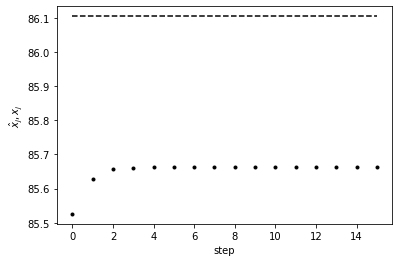

In [15]:
# plot cluster center convergence for a single cluster and coordinate
Ns = pos_list.shape[0] # number of saved steps
coord = 0
cluster = 0
plt.plot(range(Ns),pos_list[:,cluster,coord],'.k')
plt.plot(range(Ns),gt_pos[cluster,coord]*np.ones(Ns),'--k')
plt.xlabel('step')
plt.ylabel('$\hat{x}_j, x_j$');

#### plot sigma estimage convergence for a single tagger

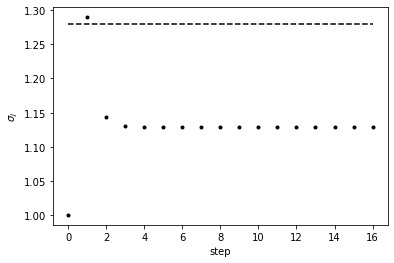

In [16]:
# plot sigma convergence for a single tagger
tagger = 0
plt.plot(range(Ns+1),sigma_list[:,tagger],'.k')
plt.plot(range(Ns+1),sigma_sq[tagger]*np.ones(Ns+1),'--k')
plt.xlabel('step')
plt.ylabel('$\sigma_j$');

#### calculate and plot MSE of coordinate estimate (averaged over all points, 2 coordinates)

In [17]:
# use real sigmas to estimate positions from tags
gt_pos_est_real_s = update_pos(clusters, sigma_sq, N)
dist_sq_real_s_est = np.sum((gt_pos_est_real_s - gt_pos)**2,axis=1)
real_sigma_MSE = np.mean(dist_sq_real_s_est)

# use equal (all 1) sigmas to estimate positions from tags
gt_pos_est_equal_s = update_pos(clusters, np.ones(sigma_sq.shape), N)
dist_sq_equal_s_est = np.sum((gt_pos_est_equal_s - gt_pos)**2,axis=1)
equal_weight_MSE = np.mean(dist_sq_equal_s_est)

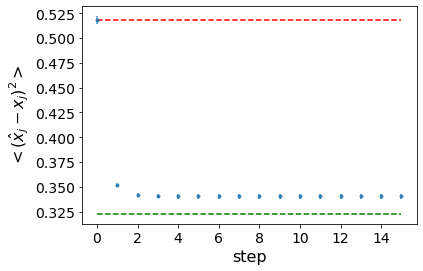

In [18]:
Ns = pos_list.shape[0] # number of saved steps
pos_diff = pos_list - np.repeat(gt_pos[np.newaxis,:, :], Ns, axis=0)
squared_dist = np.sum(pos_diff**2,axis=2)
MSE = np.mean(squared_dist,axis=1)
std_SE = np.std(squared_dist,axis=1)
std_SEM = std_SE / np.sqrt(2*N)
#plt.plot(range(Ns),mean_pos_diff,'.k')
plt.errorbar(range(Ns), MSE, yerr=std_SEM, fmt='.',alpha=0.8)
plt.xlabel('step',fontsize=16)
plt.ylabel('$< (\hat{x}_j - x_j)^2 >$',fontsize=16);
plt.plot(range(Ns),np.ones(Ns)*real_sigma_MSE,'--g')
plt.plot(range(Ns),np.ones(Ns)*equal_weight_MSE,'--r')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

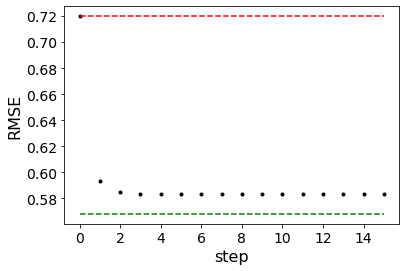

In [19]:
# plot RMSE
Ns = pos_list.shape[0] # number of saved steps
pos_diff = pos_list - np.repeat(gt_pos[np.newaxis,:, :], Ns, axis=0)
squared_dist = np.sum(pos_diff**2,axis=2)
MSE = np.mean(squared_dist,axis=1)
std_SE = np.std(squared_dist,axis=1)
std_SEM = std_SE / np.sqrt(2*N)
plt.plot(range(Ns),np.sqrt(MSE),'.k')
#plt.errorbar(range(Ns), MSE, yerr=std_SEM, fmt='.',alpha=0.8)
plt.xlabel('step',fontsize=16)
plt.ylabel('RMSE',fontsize=16);
plt.plot(range(Ns),np.ones(Ns)*np.sqrt(real_sigma_MSE),'--g')
plt.plot(range(Ns),np.ones(Ns)*np.sqrt(equal_weight_MSE),'--r')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

#### calculate and plot MSE of sigma estimage (averaged over all taggers)

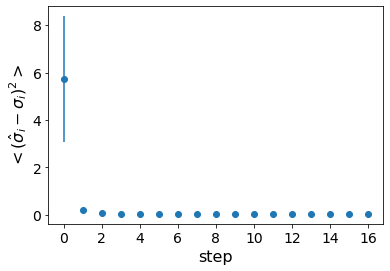

In [20]:
Ns = pos_list.shape[0] # number of saved steps
sigma_diff = sigma_list - np.repeat(sigma_sq[np.newaxis, :], Ns+1, axis=0)
MSE_sigma = np.mean(sigma_diff**2,axis=1)
std_SE_sigma = np.std(sigma_diff**2,axis=1)
std_SEM_sigma = std_SE_sigma / np.sqrt(Nt)
#plt.plot(range(Ns),mean_pos_diff,'.k')
plt.errorbar(range(Ns+1), MSE_sigma, yerr=std_SEM_sigma, fmt='o')
plt.xlabel('step',fontsize=16)
plt.ylabel('$< (\hat{\sigma}_i - \sigma_i)^2 >$',fontsize=16);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

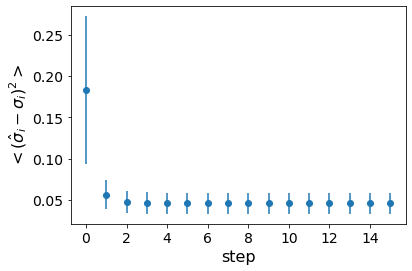

In [21]:
plt.errorbar(range(Ns), MSE_sigma[1:], yerr=std_SEM_sigma[1:], fmt='o')
plt.xlabel('step',fontsize=16)
plt.ylabel('$< (\hat{\sigma}_i - \sigma_i)^2 >$',fontsize=16);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

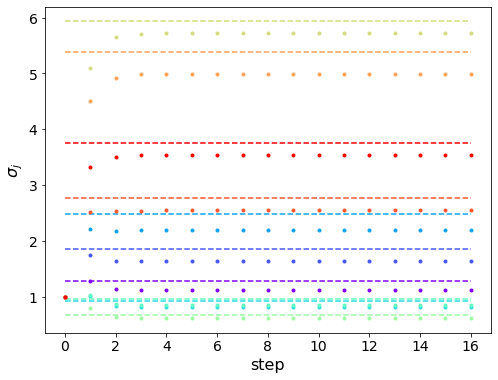

In [22]:
# plot all sigmas on same axes
color=plt.cm.rainbow(np.linspace(0,1,Nt))

plt.figure(figsize=(8,6))
for i,c in zip(range(Nt),color):
    plt.plot(range(Ns+1),sigma_list[:,i],'.', c=c)
    plt.plot(range(Ns+1),sigma_sq[i]*np.ones(Ns+1),'--', c=c)

plt.xlabel('step',fontsize=16)
plt.ylabel('$\sigma_j$',fontsize=16);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Why does sometimes the lowest sigma converge to 0?
This means the cluster gt is estimated to be closer and closer to the most precise tag, causing a positive feedback loop where its position is estimated to be more and more precise

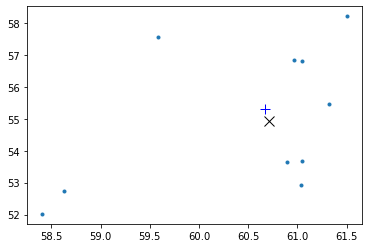

In [23]:
# plot one cluster gt, tags and estimated position
k = 7 # cluster ind
tagged_ind, tags = clusters[k]
plt.plot(tags[:,0],tags[:,1],'.')
    
# plot gt positions
plt.plot(gt_pos[k,0],gt_pos[k,1],'xk', markersize=10)

# plot gt est
plt.plot(gt_pos_est[k,0],gt_pos_est[k,1],'+b', markersize=10)

In [24]:
# # plot estimated positions
# plt.figure(figsize=(15,10))

# # plot tags
# for k in range(N):
#     tagged_ind, tags = clusters[k]
#     plt.plot(tags[:,0],tags[:,1],'.')
    
# # plot gt positions
# plt.plot(gt_pos[:,0],gt_pos[:,1],'xk', markersize=10)

# # plot gt est
# plt.plot(gt_pos_est[:,0],gt_pos_est[:,1],'+b', markersize=10)